In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import seaborn as sns

In [4]:
sns.set_context('paper', font_scale=2.2)
sns.set_style('ticks')

In [5]:
import LB_colony_growth.LB_colony_growth as lb
import LB_colony_growth.velocity_sets as vsets
from LB_colony_growth.node_types import node_types

# Setting up the domain

In [6]:
dimension = 2 # A 2-dimensional problem

# How the domain is decomposed into workgroups on the CPU/GPU
workgroup_x = 64
workgroup_y = 32

nx = 128
ny = 128

# What lattice-boltzmann velocity set to use; only D2Q9 is implemented
# for 2-d right now.
velocity_set = 'D2Q9'

# What ring of neighbors individuals can propagate to in each timestep
halo = vsets.D2Q9.halo 

In [7]:
# ctx_info: Information about the simulation that mako renders
ctx_info = {}

# Choose float or double. Most GPUs are MUCH faster when using float
# precision.
ctx_info['num_type'] = 'double'

ctx_info['nx'] = nx
ctx_info['ny'] = ny
ctx_info['nz'] = None

ctx_info['local_size'] = (workgroup_x, workgroup_y)
ctx_info['domain_size'] = (nx, ny)

ctx_info['dimension'] = dimension

# The kernel arguments dictionary needs to be initialized; responsible
# for linking python and openCL
ctx_info['kernel_arguments'] = {}

## Initializing domain boundaries

The **bc_map** is the size of the domain plus the halo in each direction. One must specify all node types on the edges of the domain, plus inside the domain.

Each node type has an integer value associated with it.

In [8]:
bc_map = np.zeros((nx + 2*halo, ny + 2*halo), dtype=lb.int_type)

bc_map[...] = node_types['FLUID_NODE']

bc_map[0, :] = node_types['PERIODIC']
bc_map[-1, :] = node_types['PERIODIC']

# Wall nodes need to overwrite periodic ones
bc_map[:, 0] = node_types['WALL_NODE']
bc_map[:, -1] = node_types['WALL_NODE']

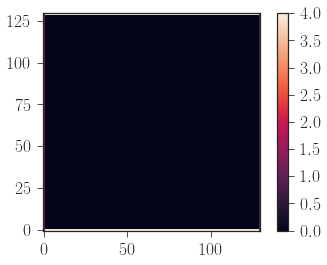

In [9]:
plt.imshow(bc_map, origin='lower')
plt.colorbar()

This bc_map illustrates a domain with periodic boundaries on the top and bottom, walls on the left and right, and fluid nodes everywhere else.

### Initializing the microbial colony

Alleles are given negative integer numbers in the **bc_map**.

In [10]:
num_alleles = 2
rand_alleles = np.random.randint(-num_alleles, 0, size=bc_map.shape)

In [11]:
height = 10
bc_map[halo:-halo, 1:1+height] = rand_alleles[halo:-halo, 1:1+height]

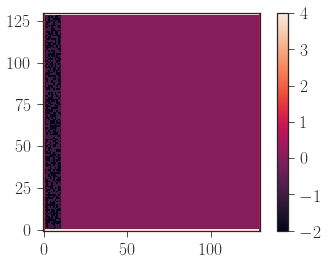

In [12]:
plt.imshow(bc_map, origin='lower')
plt.colorbar()

## The physics

### Diffusing Nutrient Field

The equation governing the diffusing nutrient field is:

$$ \frac{\partial \rho}{\partial t} = D \nabla^2 \rho$$

### Nutrient Absorption

The mass flux into a microbe is proportional to mass field outside of it ($\rho$) and is given by

$$j_\text{absorb} \cdot \hat{n} = k c $$ 

where $\hat{n}$ points into the microbe. The boundary condition on the edge of a microbe is obtained by equating the diffusive flux to the mass flux into the microbe; we find that

$$ \left( \frac{\partial \rho}{\partial n} = \frac{k \rho}{D}\right)\bigg|_\text{interface}$$

Microbes divide after absorbing an amount of mass $m_0$. The mass absorbed by a microbe $m$ per unit time is then
$$\frac{dm}{dt} = a^{d-1} k c$$

where $d$ is the dimension of the problem and $a$ is the width of a microbe. Note that microbes occupy lattice sites, so the width of a microbe in lattice units is always $1 \ \mathrm{lu}$.

### Non-dimensionalizing the set of equations

Let the characteristic mass field density in the domain be $\rho_0$. We can completely non-dimensionalize the above set of equations to read (using the subscript $d$ to illustrate a dimensionless number):

$$\frac{\partial \rho_d}{\partial t_d} = \nabla_d^2 \rho_d$$

$$\left( \frac{\partial \rho_d}{\partial n_d} = -R \rho_d \right)\bigg|_\text{interface}$$

$$\frac{d m_d}{d t_d} = \rho_d$$

where the characteristic length and time scales chosen are

$$\tau_g = \frac{m_0}{a^{d-1}\rho_0}\frac{1}{k} \equiv \text{generation time}$$

$$L = \sqrt{D \tau_g} \equiv \text{Length that nutrients diffuse per generation time}$$

and 

$$m_d = m/m_0$$
$$\rho_d = \rho/\rho_0$$

The remaining dimensionless parameter, $R$, largely controls the physics of this problem and is given by

$$R=k \sqrt{\frac{\tau_g}{D}} \equiv \mathrm{\frac{Reaction \ velocity}{Diffusion \ velocity?}}$$

Essentially, as $R \rightarrow 0$, colonies become more compact and resemble standard range expansions. As $R$ becomes larger, the colony becomes more dendritic.

## The physics: setting up the dimensionless numbers

We now specify $L$ and $R$ from above and adjust simulation parameters to obtain those values.

In [13]:
cs = vsets.D2Q9.cs # Speed of sound in lattice units; needed for lattice boltzmann

We always operate in lattice units. The width of a single lattice site is *1 lu*, or 1 lattice unit, and each time step has units of *1 ts*, or one timestep.

Similarly, density has units of $\frac{mu}{lu^3}$ where $mu$ is the mass unit.

In [14]:
### Variables that are stiff; more or less fixed ###

a = 1. #lu; width of a single lattice site
D = .5 * cs**2 # lu^2/ts


In [15]:
# Dimensionless numbers we want to change that govern the physics

L = 1. # lu: Diffusion length per division time
R = 3. # Reaction velocity vs. diffusion velocity

In [16]:
# Resulting variables

gamma = L*R
print 'gamma:', gamma

# Note that if gamma > 1, the cells will not occupy the entire domain unless more nutrients flow in...

k = (D*R/L)
print 'k:', k # lu/ts

gamma: 3.0
k: 0.5


In [17]:
### Optional choices

rho0 = 1. # mu/lu^3
m0 = rho0*gamma #mu

print 'rho_0', rho0
print 'm0', m0

rho_0 1.0
m0 3.0


In [18]:
d = dimension

tau_g = m0/(a**(d-1)*rho0*k)
print 'Generation time tau_g:', tau_g , 'ts'

L = np.sqrt(D*tau_g)
print 'Diffusion length per division time:', L, 'lu'

R = k*np.sqrt(tau_g/D)
print 'Reaction velocity vs. diffusion velocity', R

Generation time tau_g: 6.0 ts
Diffusion length per division time: 1.0 lu
Reaction velocity vs. diffusion velocity 3.0


# Finish setting up...

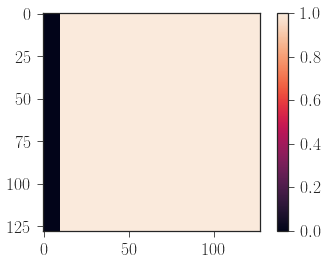

In [19]:
rho = rho0*np.ones((nx, ny), dtype=np.double) # The nutrient field
bc_in_domain = bc_map[halo:-halo, halo:-halo]

rho[bc_in_domain < 0] = 0

plt.imshow(rho)
plt.colorbar()

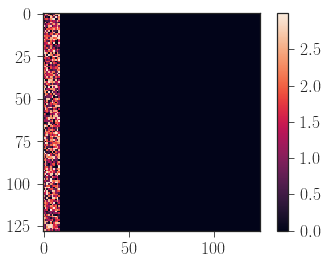

In [20]:
# Initialize the current amount of absorbed mass randomly in the microbes

absorbed_mass = m0*np.random.rand(nx, ny)
bc_in_domain = bc_map[halo:-halo, halo:-halo]

absorbed_mass[bc_in_domain >= 0] = 0

plt.imshow(absorbed_mass)
plt.colorbar()

In [21]:
k_list = num_alleles*[k] # Each allele has its own nutrient absorption rate
m_reproduce_list = num_alleles*[m0] # Each allele has its own amount of mass needed for dividsion

# Creating the simulation

In [22]:
dla_colony = lb.DLA_Colony(
    ctx_info=ctx_info, velocity_set='D2Q9',
    bc_map=bc_map, 
    D=D, k_list=k_list, m_reproduce_list=m_reproduce_list,
    absorbed_mass=absorbed_mass, rho=rho)

global size: (128, 128)
local size: (64, 32)
The platforms detected are:
---------------------------
Intel(R) OpenCL Intel(R) Corporation version: OpenCL 1.2 LINUX
The devices detected on platform Intel(R) OpenCL are:
---------------------------
       Intel(R) Core(TM) i7-3537U CPU @ 2.00GHz [Type: CPU ]
Maximum clock Frequency: 2000 MHz
Maximum allocable memory size: 2062 MB
Maximum work group size 8192
Maximum work item dimensions 3
Maximum work item size [8192L, 8192L, 8192L]
---------------------------
This context is associated with  1 devices
tau 1.0
omega 1.0
global_size_bc: (192, 160)
Connecting python to the opencl_kernel init_feq...
Connecting python to the opencl_kernel collide_and_propagate...
Creating local memory of num_type type...
Creating local memory of int type...
Connecting python to the opencl_kernel update_after_streaming...
Connecting python to the opencl_kernel reproduce...
Creating local memory of int type...
Connecting python to the opencl_kernel copy_streame

/home/bryan/git/LB_colony_growth/LB_colony_growth/LB_colony_growth.py:383: UserWarning: Received OpenCL source code in Unicode, should be ASCII string. Attempting conversion.
  self.kernels = cl.Program(self.context, buf.getvalue()).build(options='')
/home/bryan/anaconda2/lib/python2.7/site-packages/pyopencl/cffi_cl.py:1516: CompilerWarning: Built kernel retrieved from cache. Original from-source build had warnings:
Build on <pyopencl.Device 'Intel(R) Core(TM) i7-3537U CPU @ 2.00GHz' on 'Intel(R) OpenCL' at 0x7ff75c97f108> succeeded, but said:

Compilation started
Compilation done
Linking started
Linking done
Device build started
Device build done
Kernel <collide_and_propagate> was successfully vectorized (4)
Kernel <update_after_streaming> was successfully vectorized (8)
Kernel <init_feq> was successfully vectorized (8)
Kernel <reproduce> was not vectorized
Kernel <copy_streamed_onto_f> was successfully vectorized (4)
Kernel <copy_streamed_onto_bc> was successfully vectorized (4)
Done

The code works on both CPUs and GPUs. 

On my intel i7-3537U CPU running at 2GHz on a relatively old laptop, I obtain about 2 million lattice updates per second (MLUPS). This means that I can run a single iteration of the code (i.e. reproduction, nutrient absorption, etc. etc.) for 2 million lattice sites per second.

On a GTX titan black video card, I obtain closer to 200 MLUPS. Using floating point precision, I get about 400 MLUPS.

In [27]:
#%%prun -s cumtime

dla_colony.run(int(10000))

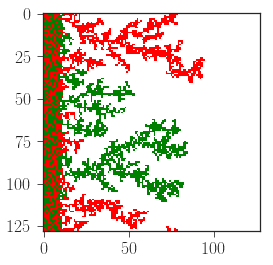

In [28]:
from matplotlib import colors

cmap = colors.ListedColormap(['white','red', 'green'])

pops = dla_colony.get_pop_field()
plt.imshow(pops, cmap=cmap)

At $R < 0.1$ or so, we get a compact colony that resembles a standard range expansion.

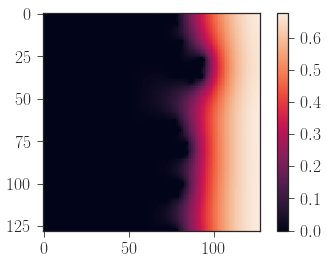

In [31]:
plt.imshow(dla_colony.rho.get())
plt.colorbar()